In [2]:
!pip install python-louvain
import networkx as nx
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import transbigdata as tbd
import mapclassify #用于数据分级的包
plt.rcParams['font.family'] = 'simsun'
plt.rcParams['axes.unicode_minus'] = False





In [3]:
df2019 = pd.read_csv('./dataset/2019-11-30.csv')##读取2019年11月30日数据
df2020 = pd.read_csv('./dataset/2020-02-20.csv')##读取2020年2月20日数据（疫情比较严重，在全国蔓延的时期）


In [4]:
df2019.head()


,Unnamed: 0,startCityAdcode,endCityAdcode,startCity,endCity,slon,slat,elon,elat,willIdx,realIdx
0,0,440600,440100,佛山,广州,112.892122,23.107847,113.280637,23.125178,56.071944,33.726111
1,1,441900,440300,东莞,深圳,113.890927,22.897877,114.085947,22.547000,55.226667,35.449444
2,2,440100,440600,广州,佛山,113.280637,23.125178,112.892122,23.107847,49.456389,33.876389
3,3,440300,441900,深圳,东莞,114.085947,22.547,113.890927,22.897877,42.524444,32.952222
4,4,320500,310000,苏州,上海,120.645957,31.401834,121.427649,31.093825,28.682222,16.215000


In [5]:
len(df2019)

109149

In [6]:
##删除缺失行
df2019.dropna()
df2020.dropna()

,Unnamed: 0,startCityAdcode,endCityAdcode,startCity,endCity,slon,slat,elon,elat,realIdx,willIdx
0,0,441900,440300,东莞,深圳,113.890927,22.897877,114.085947,22.547000,9.897778,20.044722
1,1,440600,440100,佛山,广州,112.892122,23.107847,113.280637,23.125178,8.601944,15.379444
2,2,440100,440600,广州,佛山,113.280637,23.125178,112.892122,23.107847,8.868889,14.919722
3,3,440100,441900,广州,东莞,113.280637,23.125178,113.890927,22.897877,5.430833,11.660556
4,4,320500,310000,苏州,上海,120.645957,31.401834,121.427649,31.093825,4.467222,11.488889
...,...,...,...,...,...,...,...,...,...,...,...
106008,106008,659007,530300,双河,曲靖,82.357203,44.843109,103.943748,25.699745,0.000000,0.000278
106009,106009,659007,610100,双河,西安,82.357203,44.843109,108.948024,34.263161,0.000000,0.000278
106010,106010,659007,620900,双河,酒泉,82.357203,44.843109,96.29086,40.470281,0.000000,0.000278
106011,106011,659007,640400,双河,固原,82.357203,44.843109,106.142245,35.878848,0.000278,0.000278


In [7]:
##变量解释
'''
startCityAdcode：出发城市代码
endCityAdcode：目的地城市代码
startCity：出发城市名
endCity：目的地城市名
slon：出发城市经度
slat：出发城市纬度
elon：目的地城市经度
elat：目的地城市纬度
realIdx：两地人口流动真实指数
willIdx：两地人口流动意愿指数
'''

'\nstartCityAdcode：出发城市代码\nendCityAdcode：目的地城市代码\nstartCity：出发城市名\nendCity：目的地城市名\nslon：出发城市经度\nslat：出发城市纬度\nelon：目的地城市经度\nelat：目的地城市纬度\nrealIdx：两地人口流动真实指数\nwillIdx：两地人口流动意愿指数\n'

In [8]:
#查看数据信息
df2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109149 entries, 0 to 109148
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       109149 non-null  int64  
 1   startCityAdcode  109149 non-null  int64  
 2   endCityAdcode    109149 non-null  int64  
 3   startCity        109145 non-null  object 
 4   endCity          109111 non-null  object 
 5   slon             105990 non-null  float64
 6   slat             108411 non-null  object 
 7   elon             109073 non-null  object 
 8   elat             102882 non-null  float64
 9   willIdx          109149 non-null  float64
 10  realIdx          109149 non-null  float64
dtypes: float64(4), int64(3), object(4)
memory usage: 9.2+ MB


In [9]:
##发现slat 和 elon 都是object 需要转成flost 
df2019["slat"] = pd.to_numeric(df2019["slat"],errors='coerce')
df2019["elon"] = pd.to_numeric(df2019["elon"],errors='coerce')
df2020["slat"] = pd.to_numeric(df2020["slat"],errors='coerce')
df2020["elon"] = pd.to_numeric(df2020["elon"],errors='coerce')

In [10]:
##查看数据分布，可以看出2019这天很多城市之间真实人口流动指数为0,因此我们需要做一些数据筛选
df2019.describe()

,Unnamed: 0,startCityAdcode,endCityAdcode,slon,slat,elon,elat,willIdx,realIdx
count,109149.000000,109149.000000,109149.000000,105990.000000,108335.000000,105227.000000,102882.000000,109149.000000,109149.000000
mean,54574.000000,403059.959294,407702.919065,112.217635,34.256057,110.156534,32.610923,0.036514,0.018332
std,31508.746603,147217.092169,148227.716156,8.881591,13.344080,14.928735,7.017085,0.462293,0.293503
min,0.000000,110000.000000,110000.000000,74.633998,18.382989,18.382989,18.382989,0.000278,0.000000
25%,27287.000000,330300.000000,330400.000000,107.536892,27.497971,106.626155,27.450961,0.000833,0.000000
50%,54574.000000,420300.000000,421000.000000,113.384091,32.390934,113.029824,32.041544,0.002222,0.000278
75%,81861.000000,511300.000000,511800.000000,117.939152,37.735097,117.527263,37.494847,0.008333,0.001667
max,109148.000000,820000.000000,820000.000000,132.501692,132.501692,132.501692,52.232872,56.071944,35.449444


In [11]:
##将高德坐标系转成wgs84坐标系
df2019['slon'],df2019['slat'] = tbd.gcj02towgs84(df2019['slon'],df2019['slat'])
df2019['elon'],df2019['elat'] = tbd.gcj02towgs84(df2019['elon'],df2019['elat'])
df2020['slon'],df2020['slat'] = tbd.gcj02towgs84(df2020['slon'],df2020['slat'])
df2020['elon'],df2020['elat'] = tbd.gcj02towgs84(df2020['elon'],df2020['elat'])

In [12]:
df2019.columns##查看列名

Index(['Unnamed: 0', 'startCityAdcode', 'endCityAdcode', 'startCity',
       'endCity', 'slon', 'slat', 'elon', 'elat', 'willIdx', 'realIdx'],
      dtype='object')

In [13]:
##提取真实流动指数大于0.01的城市
df2019 = df2019[df2019['realIdx']>0.01]
df2020 = df2020[df2020['realIdx']>0.01]

In [14]:
len(df2019)

10169

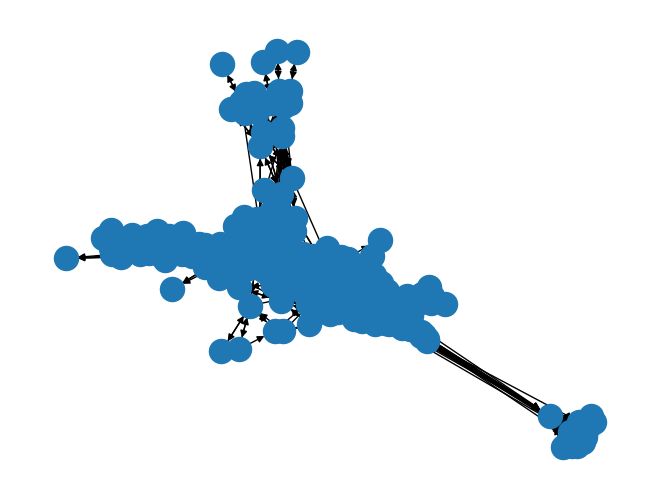

In [15]:
##构建流动网络，并作简单可视化
D = nx.from_pandas_edgelist(df2019,source='startCity',target='endCity',edge_attr='realIdx',create_using=nx.DiGraph)##创建有向图
##绘制网络图，由于没有输入具体的坐标，所以网络看起来一团乱麻，因此我们不仅需要构建每个节点的坐标，还需添加底图
nx.draw(D)

In [16]:
#读取全国市级行政区划,市级地图
shi = gpd.read_file('./dataset/市.json')

In [17]:
## 查看坐标系，坐标系是wgs84的，与我们上面转换的一样
shi.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

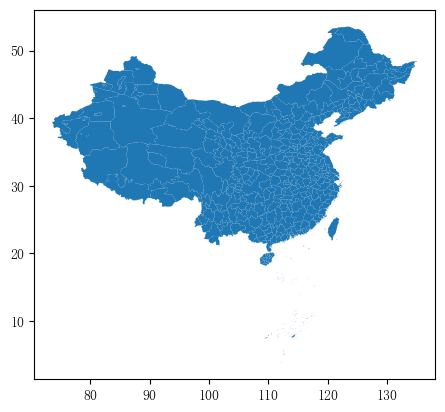

In [18]:
shi.plot()

In [19]:
# 读取国界和九段线
xian = gpd.read_file('./dataset/九段线.json')

<Axes: >

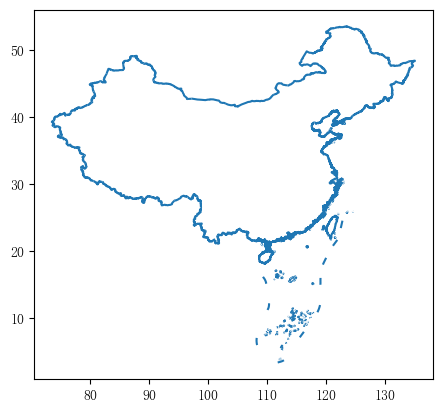

In [20]:
xian.plot()

In [21]:
df2019['realIdx']

0        33.726111
1        35.449444
2        33.876389
3        32.952222
4        16.215000
           ...    
21378     0.010833
21952     0.010556
21954     0.010278
23070     0.010278
23257     0.010833
Name: realIdx, Length: 10169, dtype: float64

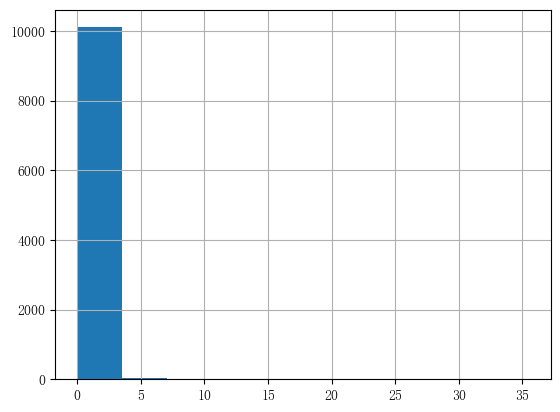

In [22]:
#参考数据分布极不均衡
df2019['realIdx'].hist()
plt.show()

In [23]:
##使用自然断点法分为3级
real = mapclassify.NaturalBreaks(df2019['realIdx'],k=3).bins

In [24]:
real

array([ 3.0575    , 16.60722222, 35.44944444])

In [25]:
##设置区间
L3 = df2019[df2019['realIdx'] > real[1]]
L2 = df2019[(df2019['realIdx'] > real[0]) & (df2019['realIdx'] <= real[1])]
L1 = df2019[df2019['realIdx'] <= real[0]]

In [26]:
real2 = [0]+list(real)
real2

[0, 3.0575, 16.60722222, 35.44944444]

In [27]:
##设置区间，四舍五入
['{:.0f}-{:.0f}'.format(real2[i],real2[i+1]) for i in range(3)]

['0-3', '3-17', '17-35']

In [28]:
#提取不同区间的网络
lst = [L1,L2,L3]
graph_lst = [nx.from_pandas_edgelist(i,source='startCity',target='endCity',edge_attr='realIdx',create_using=nx.DiGraph) for i in lst]

In [29]:
##提取城市唯一值
pos =df2019['endCity'].unique()

In [30]:
##共有366个城市
len(pos)

366

In [31]:
 ##提取这366个城市的经纬度
 dfpos = df2019.drop_duplicates(subset = "endCity").reset_index()

In [32]:
 dfpos

,index,Unnamed: 0,startCityAdcode,endCityAdcode,startCity,endCity,slon,slat,elon,elat,willIdx,realIdx
0,0,0,440600,440100,佛山,广州,112.887085,23.110722,113.275292,23.127843,56.071944,33.726111
1,1,1,441900,440300,东莞,深圳,113.886029,22.900833,114.080818,22.549684,55.226667,35.449444
2,2,2,440100,440600,广州,佛山,113.275292,23.127843,112.887085,23.110722,49.456389,33.876389
3,3,3,440300,441900,深圳,东莞,114.080818,22.549684,113.886029,22.900833,42.524444,32.952222
4,4,4,320500,310000,苏州,上海,120.641737,31.403943,121.423027,31.095745,28.682222,16.215000
...,...,...,...,...,...,...,...,...,...,...,...,...
361,6692,6692,652800,659006,巴音郭楞蒙古,铁门关,88.142835,39.603954,85.500706,41.826035,0.060833,0.053611
362,7266,7266,652700,659007,博尔塔拉蒙古,双河,81.840129,44.694236,82.354008,44.842104,0.054444,0.047222
363,7267,7267,653200,659009,和田,昆玉,81.192366,36.978877,NaN,NaN,0.054444,0.053056
364,9479,9479,632800,632600,海西蒙古族藏族,果洛藏族,94.903216,37.232730,99.355468,34.073366,0.038333,0.015556


In [33]:
##网络的节点坐标需要一个字典，因此我们构建一个节点坐标字典
pos_dic = {}
for i in range(len(pos)):
    pos_dic[dfpos['endCity'][i]] = [dfpos['elon'][i],dfpos['elat'][i]]

In [34]:
## 绘制网络空间图时我们会绘制把省会城市绘制出来，因此我们提取省会城市的坐标
pos1 = pd.read_csv('./dataset/pos.csv')
sh = pos1[pos1['省会'] == 'Y'].reset_index()

In [35]:
##构建省会城市坐标字典
sh_dic = {}
for i in range(len(sh)):
    sh_dic[sh['NAME'][i]] = [sh['经度'][i],sh['纬度'][i]]

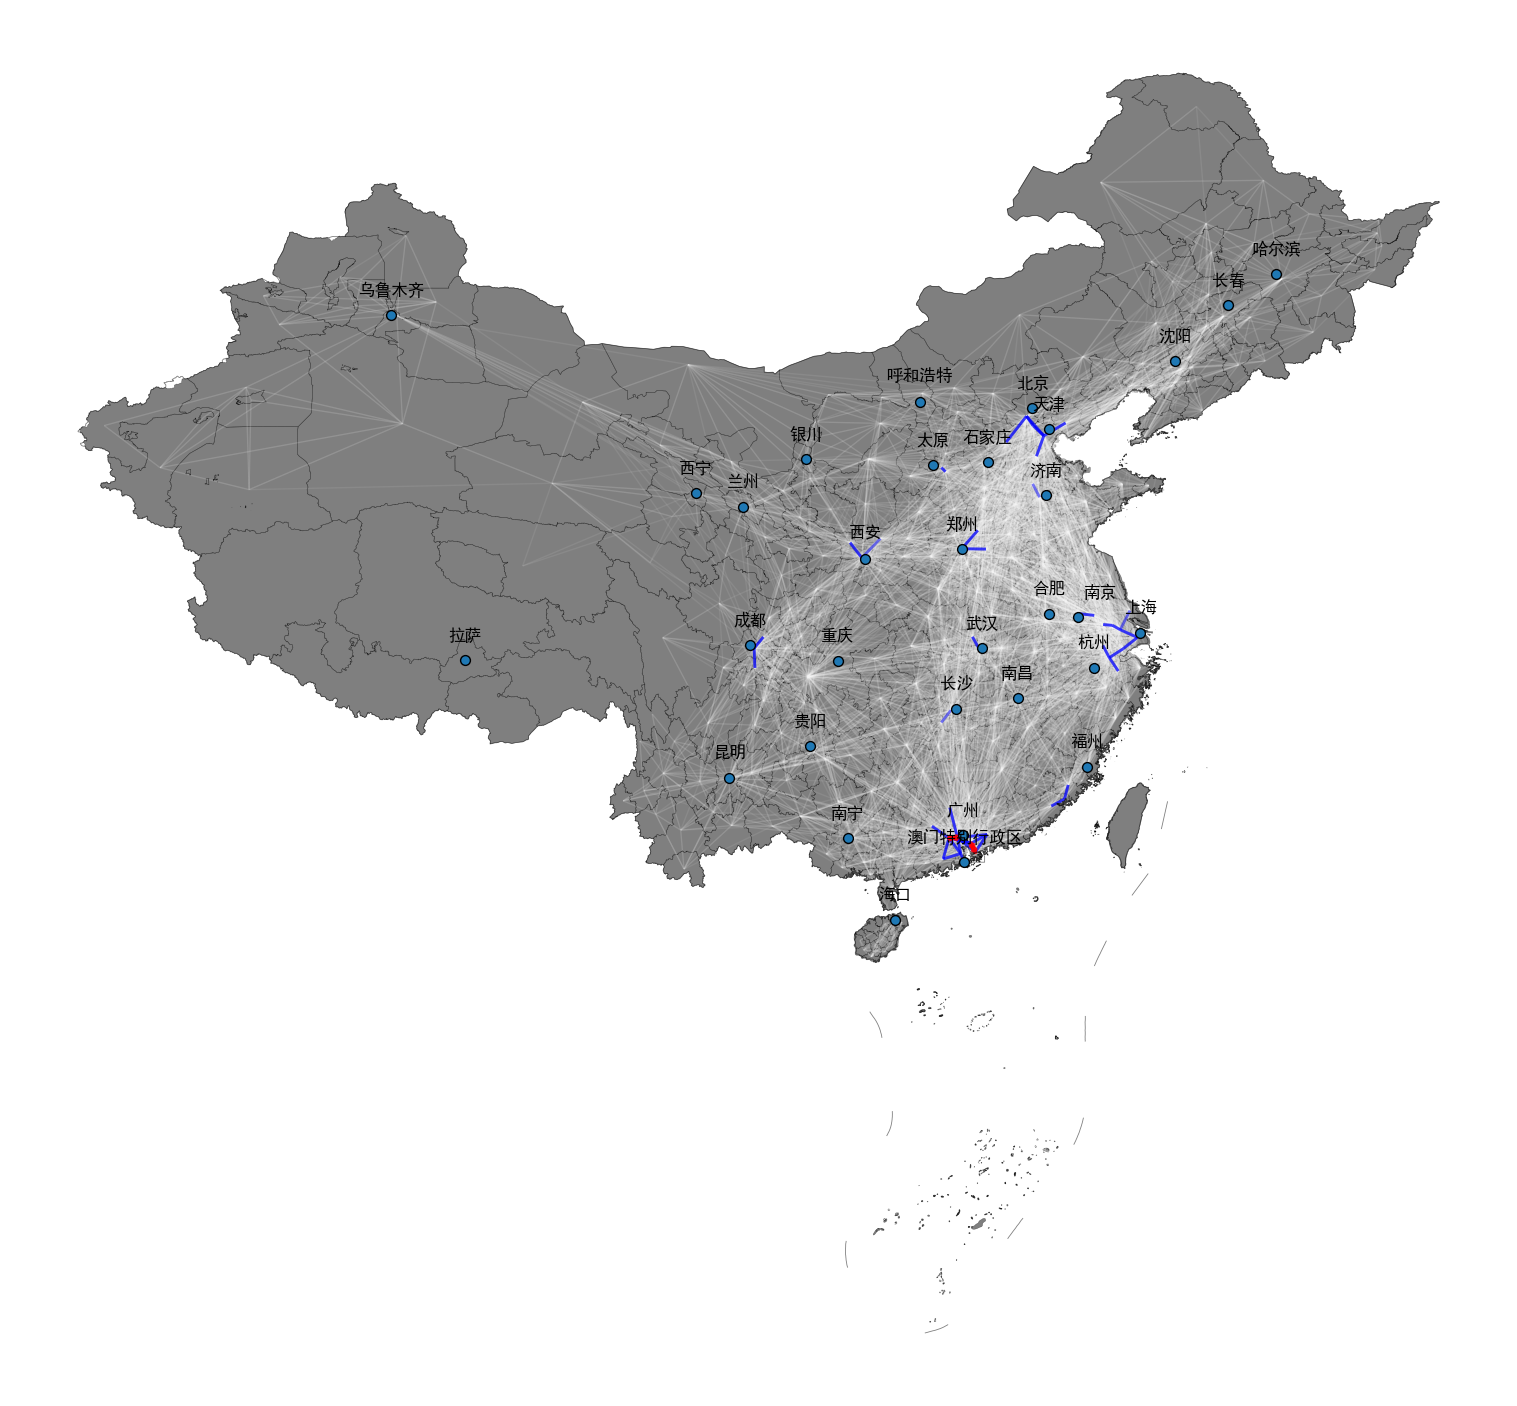

In [36]:
fig,ax = plt.subplots(figsize=(24,18))
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
##绘制底图
shi.plot(ax=ax,facecolor='k',edgecolor='k',alpha=0.5,lw=0.3)
xian.plot(ax=ax,edgecolor='k',facecolor='none',alpha=0.5,lw=0.6)
##绘制网络
nx.draw(D,pos=pos_dic,node_size=0,alpha=0,arrows=False)

line_width = [1,2,3]#设置不同级别线宽
edge_color = ['white','blue','red']#设置不同的颜色
alpha=[0.08,0.5,0.8]

level = ['{:.0f}-{:.0f}'.format(real2[i],real2[i+1]) for i in range(3)]

for i in range(3):
    if i >= 2:
        nx.draw_networkx_edges(graph_lst[i],pos=pos_dic,
                               width=line_width[i],edge_color=edge_color[i],alpha=alpha[i],
                              arrows=True,arrowsize=5,label=level[i])##最高一级画上箭头
    else:
        nx.draw_networkx_edges(graph_lst[i],pos=pos_dic,
                               width=line_width[i],edge_color=edge_color[i],alpha=alpha[i],
                              arrows=False,label=level[i])##其他的不画

##绘制省会城市名称
sh_dic2 = {}
for k,v in sh_dic.items():
    if k != '南京': #南京和上海字会重叠，所以画远一点
        sh_dic2[k] = [v[0],v[1]+1] ##其他城市名称纬度高1度
    else:
        sh_dic2[k] = [v[0]+1,v[1]+1] ##南京的经纬度都高1度
        
G = nx.Graph()
G.add_nodes_from(sh_dic.keys())
##绘制真实的省会位置，但不显示名称
nx.draw(G,pos=sh_dic,nodelist=sh_dic.keys(),node_size=50,with_labels=False,edgecolors='k')

## 绘制并显示位置偏移过的省会城市名称，但不显示位置
nx.draw(G,pos=sh_dic2,nodelist=sh_dic.keys(),node_size=0,with_labels=True,font_family='SimHei')

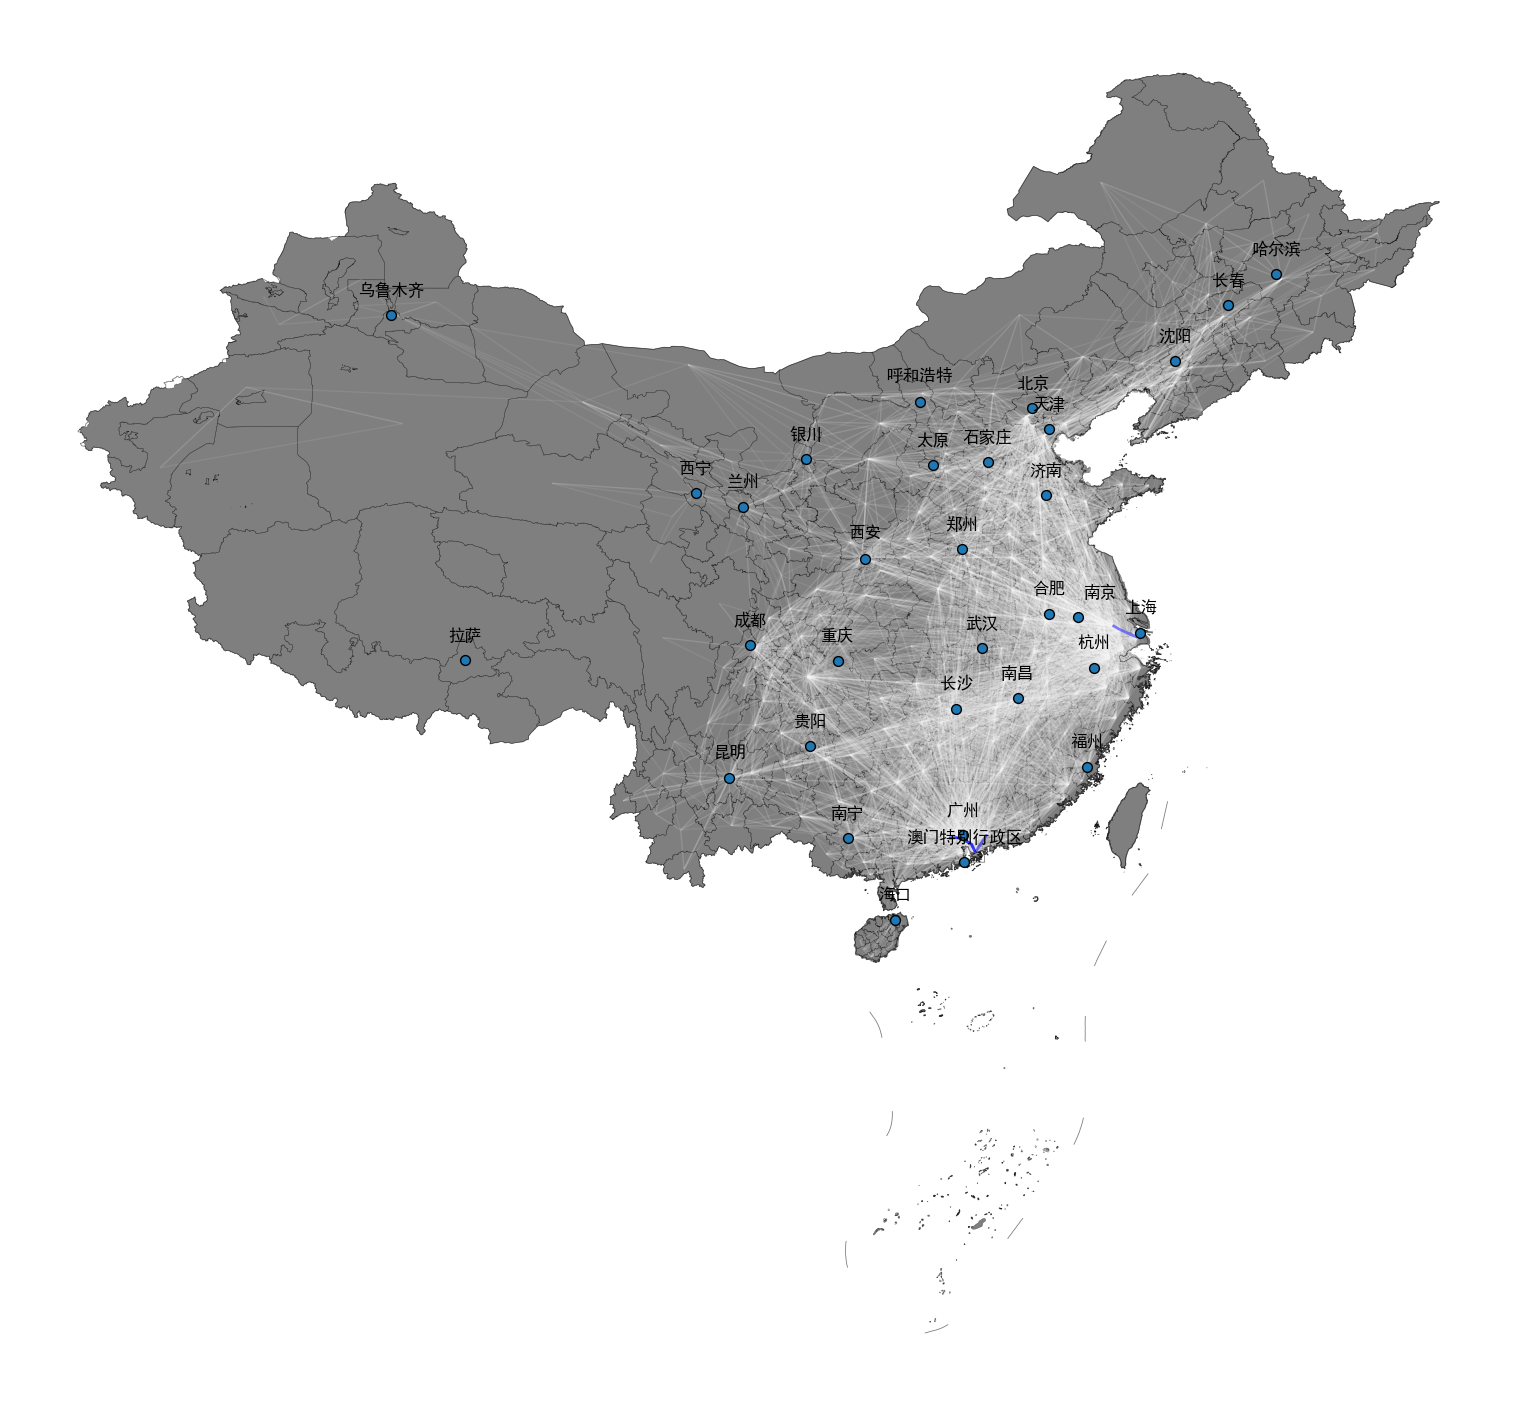

In [37]:
##把绘制2019年的代码重新运行一遍,为了可对比，我们分级的值不变
D2 = nx.from_pandas_edgelist(df2020,source='startCity',target='endCity',edge_attr='realIdx',create_using=nx.DiGraph)##创建有向图
L3 = df2020[df2020['realIdx'] > real[1]]
L2 = df2020[(df2020['realIdx'] > real[0]) & (df2020['realIdx'] <= real[1])]
L1 = df2020[df2020['realIdx'] <= real[0]]

#提取不同区间的网络
lst = [L1,L2,L3]
graph_lst = [nx.from_pandas_edgelist(i,source='startCity',target='endCity',edge_attr='realIdx',create_using=nx.DiGraph) for i in lst]


fig,ax = plt.subplots(figsize=(24,18))
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
##绘制底图
shi.plot(ax=ax,facecolor='k',edgecolor='k',alpha=0.5,lw=0.3)
xian.plot(ax=ax,edgecolor='k',facecolor='none',alpha=0.5,lw=0.6)
##绘制网络
nx.draw(D2,pos=pos_dic,node_size=0,alpha=0,arrows=False)

line_width = [1,2,3]#设置不同级别线宽
edge_color = ['white','blue','red']#设置不同的颜色
alpha=[0.08,0.5,0.8]

level = ['{:.0f}-{:.0f}'.format(real2[i],real2[i+1]) for i in range(3)]

for i in range(3):
    if i >= 2:
        nx.draw_networkx_edges(graph_lst[i],pos=pos_dic,
                               width=line_width[i],edge_color=edge_color[i],alpha=alpha[i],
                              arrows=True,arrowsize=5,label=level[i])##最高一级画上箭头
    else:
        nx.draw_networkx_edges(graph_lst[i],pos=pos_dic,
                               width=line_width[i],edge_color=edge_color[i],alpha=alpha[i],
                              arrows=False,label=level[i])##其他的不画

##绘制省会城市名称
sh_dic2 = {}
for k,v in sh_dic.items():
    if k != '南京': #南京和上海字会重叠，所以画远一点
        sh_dic2[k] = [v[0],v[1]+1] ##其他城市名称纬度高1度
    else:
        sh_dic2[k] = [v[0]+1,v[1]+1] ##南京的经纬度都高1度
        
G = nx.Graph()
G.add_nodes_from(sh_dic.keys())
##绘制真实的省会位置，但不显示名称
nx.draw(G,pos=sh_dic,nodelist=sh_dic.keys(),node_size=50,with_labels=False,edgecolors='k')

## 绘制并显示位置偏移过的省会城市名称，但不显示位置
nx.draw(G,pos=sh_dic2,nodelist=sh_dic.keys(),node_size=0,with_labels=True,font_family='SimHei')

In [38]:
df2019 = pd.read_csv('./dataset/2019-11-30.csv')##读取2019年11月30日数据
df2020 = pd.read_csv('./dataset/2020-02-20.csv')##读取2020年2月20日数据（疫情比较严重，在全国蔓延的时期）

##发现slat 和 elon 都是object 需要转成flost 
df2019["slat"] = pd.to_numeric(df2019["slat"],errors='coerce')
df2019["elon"] = pd.to_numeric(df2019["elon"],errors='coerce')
df2020["slat"] = pd.to_numeric(df2020["slat"],errors='coerce')
df2020["elon"] = pd.to_numeric(df2020["elon"],errors='coerce')

In [39]:
# 使用透视表构建真实出行指数矩阵
matrix = df2019.pivot_table(index='startCityAdcode',columns='endCityAdcode',values='realIdx',aggfunc=np.sum )

In [40]:
matrix

endCityAdcode,110000,120000,130100,130200,130300,130400,130500,130600,130700,130800,...,659003,659004,659005,659006,659007,659008,659009,710000,810000,820000
startCityAdcode,,,,,,,,,,,,,,,,,,,,,
110000,NaN,4.268889,0.545278,0.906111,0.225278,0.262222,0.196111,4.580556,1.795556,0.871667,...,0.0,0.000000,0.0,0.0,NaN,0.0,NaN,0.0,0.000833,0.000556
120000,4.507500,NaN,0.360000,4.178056,1.000000,0.221667,0.151389,0.995000,0.126389,0.209167,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.000833,0.000278
130100,0.570278,0.260833,NaN,0.110278,0.035833,0.698056,2.260833,2.383333,0.112222,0.024722,...,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.000278,0.000000
130200,0.928611,3.266389,0.151944,NaN,1.752778,0.089722,0.046944,0.242778,0.038611,0.357778,...,0.0,0.000278,NaN,NaN,NaN,NaN,NaN,0.0,0.000278,0.000000
130300,0.256667,0.558889,0.047500,1.390278,NaN,0.043611,0.019722,0.080278,0.005833,0.070000,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,...,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
659009,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
710000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
matrix = matrix.fillna(0) ##填充缺失值
#构建两地出行指列表
md = matrix.to_dict()
lst = []

for m,n in md.items():
    for k,v in n.items():
        if m != k:
            if v!=0:
                tp = [m,k,v]
                lst.append(tp)
                

In [42]:
##将刚刚的列表转化成DataFrame格式
vl = pd.DataFrame(lst,columns=['a','b','links'])

In [43]:
vl

,a,b,links
0,110000,120000,4.507500
1,110000,130100,0.570278
2,110000,130200,0.928611
3,110000,130300,0.256667
4,110000,130400,0.250000
...,...,...,...
66688,820000,532300,0.000278
66689,820000,533100,0.000278
66690,820000,610700,0.000278
66691,820000,620100,0.000278


In [44]:
## 将两地的人流量进行求和，比如上海到广州加上广州到上海的量就是这两个城市总的出行量
vl['x'] = vl[['a','b']].apply(lambda x:x[0] if x[0]>x[1] else x[1],axis=1)
vl['y'] = vl[['a','b']].apply(lambda x:x[1] if x[0]>x[1] else x[0],axis=1)
vl = vl.groupby(by=['x','y']).sum().reset_index()

In [45]:
G = nx.from_pandas_edgelist(vl,source='x',target='y',edge_attr='links') ##构建出行网络

In [46]:
! pip install python-louvain -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [47]:


import networkx as nx
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt

# 使用 Louvain 算法进行社区发现
community = community_louvain.best_partition(G, weight='links', resolution=10)



In [48]:
##可以看到每个城市被编入不同的社区，后面的代码代表了一个社区
community

{120000: 0,
 110000: 1,
 130100: 2,
 130200: 0,
 130300: 0,
 130400: 2,
 130500: 2,
 130600: 1,
 130700: 1,
 130800: 3,
 130900: 0,
 131000: 1,
 131100: 2,
 140100: 4,
 140200: 4,
 140300: 4,
 140400: 6,
 140500: 6,
 140600: 4,
 140700: 4,
 140800: 6,
 140900: 4,
 141000: 6,
 141100: 4,
 150100: 28,
 150200: 28,
 150300: 28,
 150400: 3,
 150500: 11,
 150600: 28,
 150700: 11,
 150800: 28,
 150900: 28,
 152200: 11,
 152500: 3,
 152900: 28,
 210100: 12,
 210200: 12,
 210300: 12,
 210400: 12,
 210500: 12,
 210600: 12,
 210700: 12,
 210800: 12,
 210900: 12,
 211000: 12,
 211100: 12,
 211200: 12,
 211300: 3,
 211400: 12,
 220100: 11,
 220200: 11,
 220300: 11,
 220400: 11,
 220500: 11,
 220600: 11,
 220700: 11,
 220800: 11,
 222400: 11,
 230100: 11,
 230200: 11,
 230300: 11,
 230400: 11,
 230500: 11,
 230600: 11,
 230700: 11,
 230800: 11,
 230900: 11,
 231000: 11,
 231100: 11,
 231200: 11,
 232700: 11,
 310000: 14,
 320100: 25,
 320200: 16,
 320300: 20,
 320400: 16,
 320500: 14,
 320600: 18,


In [49]:
##将社区发现的结果并入市级行政区划中去
shi['type'] = shi['市代码'].map(community)

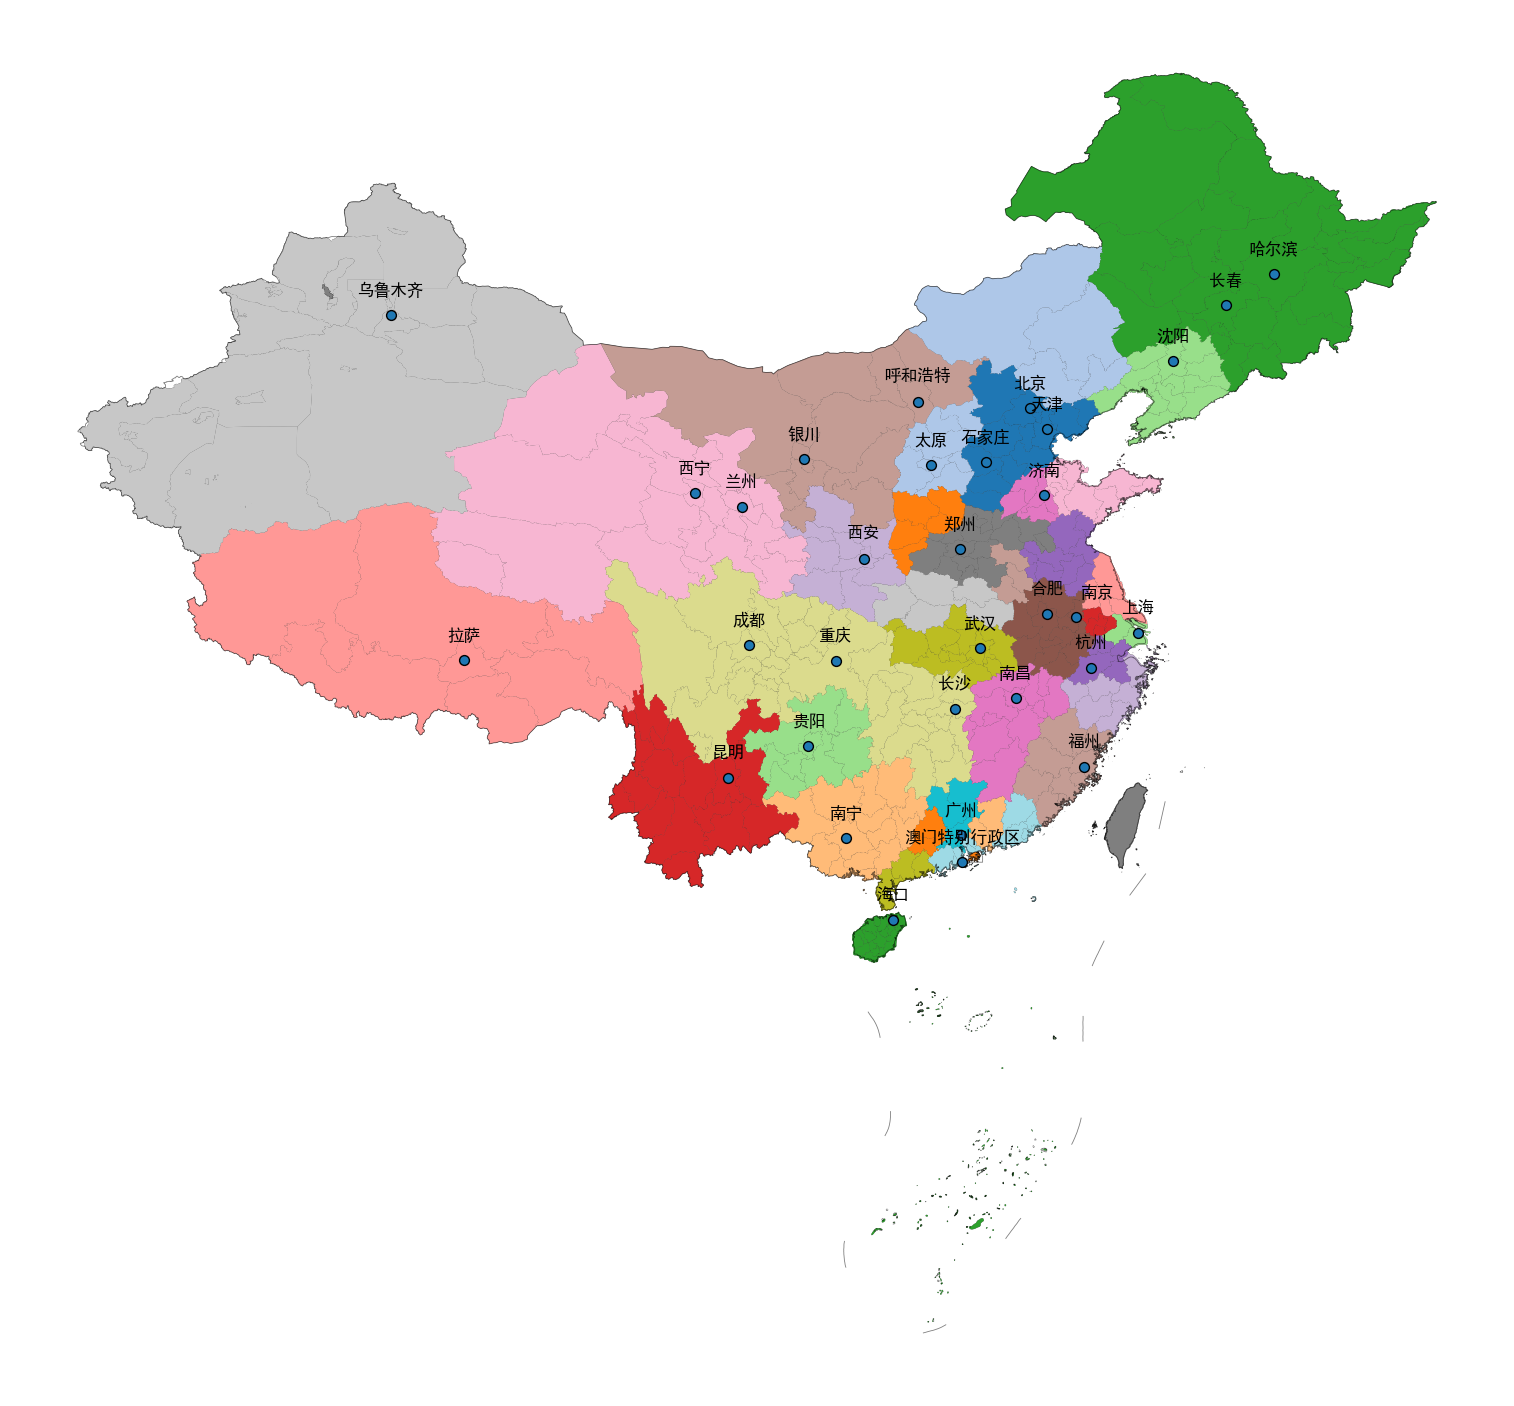

In [50]:
fig,ax = plt.subplots(figsize=(24,18))
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
##绘制底图
shi.plot(ax=ax,facecolor='k',edgecolor='k',alpha=0.5,lw=0.3)
xian.plot(ax=ax,edgecolor='k',facecolor='none',alpha=0.5,lw=0.6)
shi.plot(ax=ax,column='type',cmap='tab20',figsize=(24,18))
G = nx.Graph()
G.add_nodes_from(sh_dic.keys())
##绘制省会城市名称
sh_dic2 = {}
for k,v in sh_dic.items():
    if k != '南京': #南京和上海字会重叠，所以画远一点
        sh_dic2[k] = [v[0],v[1]+1] ##其他城市名称纬度高1度
    else:
        sh_dic2[k] = [v[0]+1,v[1]+1] ##南京的经纬度都高1度
##绘制真实的省会位置，但不显示名称
nx.draw(G,pos=sh_dic,nodelist=sh_dic.keys(),node_size=50,with_labels=False,edgecolors='k')

## 绘制并显示位置偏移过的省会城市名称，但不显示位置
nx.draw(G,pos=sh_dic2,nodelist=sh_dic.keys(),node_size=0,with_labels=True,font_family='SimHei')